## Music Genre Classification

### Setting up Kaggle to get Dataset

In [1]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download andradaolteanu/gtzan-dataset-music-genre-classification

100% 1.21G/1.21G [00:07<00:00, 115MB/s]
100% 1.21G/1.21G [00:07<00:00, 169MB/s]


In [2]:
! unzip gtzan-dataset-music-genre-classification

Archive:  gtzan-dataset-music-genre-classification.zip
  inflating: Data/features_30_sec.csv  
  inflating: Data/features_3_sec.csv  
  inflating: Data/genres_original/blues/blues.00000.wav  
  inflating: Data/genres_original/blues/blues.00001.wav  
  inflating: Data/genres_original/blues/blues.00002.wav  
  inflating: Data/genres_original/blues/blues.00003.wav  
  inflating: Data/genres_original/blues/blues.00004.wav  
  inflating: Data/genres_original/blues/blues.00005.wav  
  inflating: Data/genres_original/blues/blues.00006.wav  
  inflating: Data/genres_original/blues/blues.00007.wav  
  inflating: Data/genres_original/blues/blues.00008.wav  
  inflating: Data/genres_original/blues/blues.00009.wav  
  inflating: Data/genres_original/blues/blues.00010.wav  
  inflating: Data/genres_original/blues/blues.00011.wav  
  inflating: Data/genres_original/blues/blues.00012.wav  
  inflating: Data/genres_original/blues/blues.00013.wav  
  inflating: Data/genres_original/blues/blues.00014.wa

### Installing Libraries

In [4]:
!pip install librosa

In [5]:
!pip install pydub

### Adding imports

In [101]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

import librosa
import librosa.display as lplt
import IPython

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense,Dropout

import pickle

### Data Analysis

In [8]:
df = pd.read_csv("Data/features_3_sec.csv")
df.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,blues.00000.3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,blues.00000.4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


In [9]:
print("Dataset has",df.shape)
print("Count of samples for each genre")
df.label.value_counts().reset_index()

Dataset has (9990, 60)
Count of samples for each genre


,index,label
0,blues,1000
1,jazz,1000
2,metal,1000
3,pop,1000
4,reggae,1000
5,disco,999
6,classical,998
7,hiphop,998
8,rock,998
9,country,997


In [10]:
audio_fp = 'Data/genres_original/blues/blues.00000.wav'
audio_data, sr = librosa.load(audio_fp)
audio_data, _ = librosa.effects.trim(audio_data)

In [11]:
IPython.display.Audio(audio_data, rate=sr)

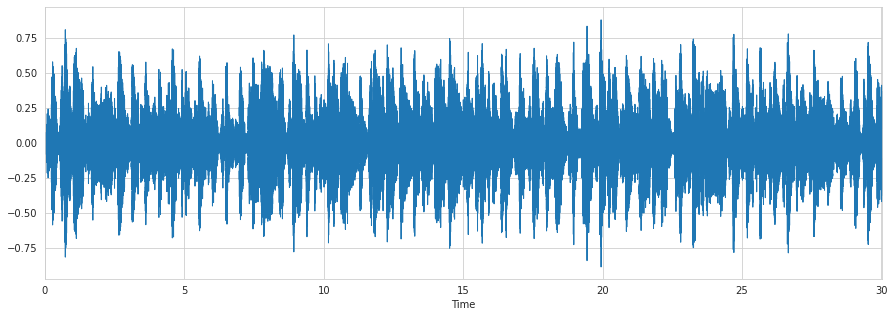

In [12]:
plt.figure(figsize=(15,5))
lplt.waveplot(audio_data)
plt.show()

#### Spectrogram
A spectrogram is a visual way of representing the signal loudness of a signal over time at various frequencies present in a particular waveform. Not only can one see whether there is more or less energy at, for example, 2 Hz vs 10 Hz, but one can also see how energy levels vary over time.

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:1642: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  "amplitude_to_db was called on complex input so phase "


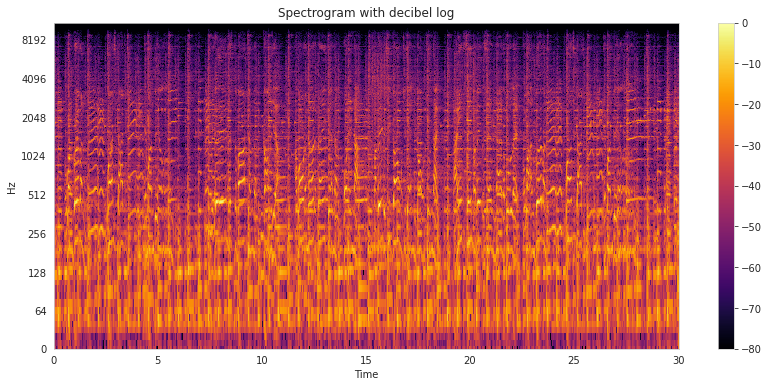

In [13]:
stft = librosa.stft(audio_data)
stft_db = librosa.amplitude_to_db(stft, ref=np.max)

plt.figure(figsize=(14,6))
lplt.specshow(stft_db, sr=sr, x_axis='time', y_axis='log', cmap='inferno')
plt.colorbar()
plt.title("Spectrogram with decibel log")
plt.show()


#### Chroma Feature

It is a powerful tool for analyzing music features whose pitches can be meaningfully categorized and whose tuning approximates to the equal-tempered scale. One main property of chroma features is that they capture harmonic and melodic characteristics of music while being robust to changes in timbre and instrumentation


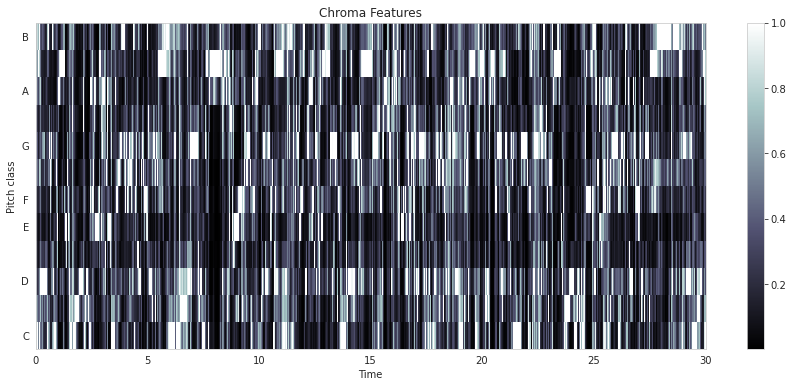

In [14]:
chroma = librosa.feature.chroma_stft(audio_data,sr=sr)
plt.figure(figsize=(15,6))
lplt.specshow(chroma,sr=sr,x_axis="time",y_axis="chroma",cmap="bone")
plt.colorbar()
plt.title("Chroma Features")
plt.show()


#### Zero Crossing Rate

Zero crossing is said to occur if successive samples have different algebraic signs. The rate at which zero-crossings occur is a simple measure of the frequency content of a signal. Zero-crossing rate is a measure of the number of times in a given time interval/frame that the amplitude of the speech signals passes through a value of zero.


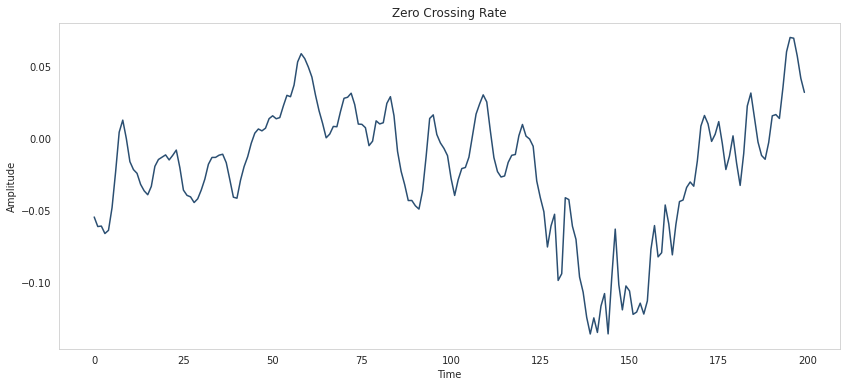

In [15]:
start=1000
end=1200
plt.figure(figsize=(14,6))
plt.title("Zero Crossing Rate")
plt.ylabel("Amplitude")
plt.xlabel("Time")
plt.plot(audio_data[start:end],color="#2B4F72")
plt.grid()

#### Correlation heatmap

Text(0.5, 1.0, 'Correlation Heatmap (for the MEAN variables)')

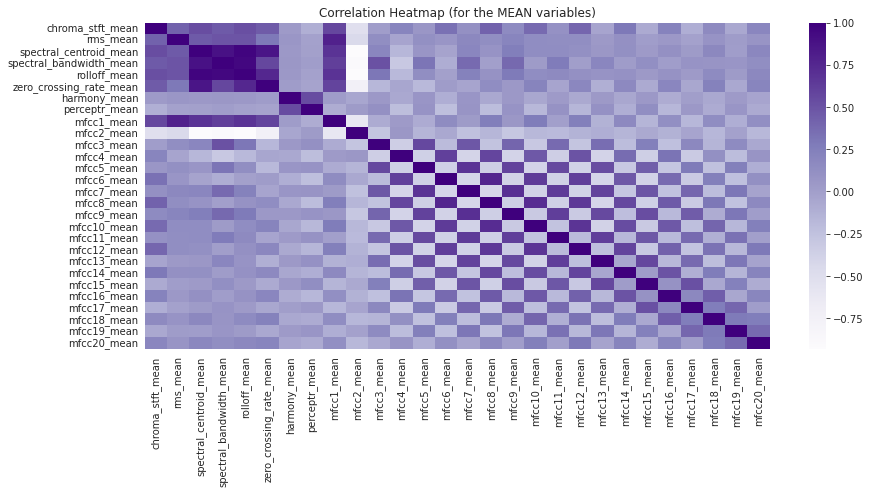

In [16]:
spike_cols = [col for col in df.columns if 'mean' in col]
corr = df[spike_cols].corr()
plt.figure(figsize=(14,6))
sns.heatmap(corr, cmap="Purples")

plt.title('Correlation Heatmap (for the MEAN variables)')

pca and box wala ka dekhna padega thoda ☹

### Data Preparation

#### Checking for missing values

In [17]:
df.columns[df.isnull().any()]

Index([], dtype='object')

#### Encoding

In [18]:
label_encoder = LabelEncoder()
label_encoder = label_encoder.fit_transform(df[["label"]])
label_encoder

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0, 0, 0, ..., 9, 9, 9])

In [19]:
df.label = label_encoder

#### Scaling data
Standard scaler is used to standardize features by removing the mean and scaling to unit variance. The standard score of sample x is calculated as: z = (x - u) / s

In [20]:
df.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,0
1,blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,0
2,blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,0
3,blues.00000.3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,0
4,blues.00000.4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,0


In [21]:
dff = df.loc[:, ~df.columns.isin(['perceptr_mean','perceptr_var'])]
dff.shape

(9990, 58)

In [22]:
scaler=StandardScaler()
X=scaler.fit_transform(np.array(dff.iloc[:,1:-1],dtype=float))

In [23]:
y = dff.iloc[:,-1]

In [24]:
X,y

(array([[ 0.        , -0.48780784,  0.64052047, ..., -0.51356204,
          0.12841417, -0.29178072],
        [ 0.        , -0.40314187,  0.13183473, ...,  1.01138445,
          1.27578001,  0.05642464],
        [ 0.        , -0.36169428,  0.7644909 , ..., -0.04624405,
          0.65390663, -0.52145798],
        ...,
        [ 0.        , -0.35433044,  0.42997426, ..., -0.15370124,
          0.11765485, -0.33882395],
        [ 0.        ,  0.0883611 , -0.00630133, ..., -0.72456977,
          0.30333409, -0.95893743],
        [ 0.        , -0.11321002,  0.19536324, ..., -0.37245283,
         -0.47495901, -0.55112155]]), 0       0
 1       0
 2       0
 3       0
 4       0
        ..
 9985    9
 9986    9
 9987    9
 9988    9
 9989    9
 Name: label, Length: 9990, dtype: int64)

#### Create training and testing datasets

In [63]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

### Building the model

In [85]:
model = Sequential()
model.add(Dense(625, activation="relu",input_shape=(X_train.shape[1],)))
model.add(Dropout(0.2))
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(235, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(111, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(50, activation="relu"))
model.add(Dense(10, activation="softmax"))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=300, batch_size=128)
model.summary()

Epoch 1/300
63/63 [==============================] - 2s 28ms/step - loss: 1.5051 - accuracy: 0.4608 - val_loss: 0.9793 - val_accuracy: 0.6572
Epoch 2/300
63/63 [==============================] - 2s 36ms/step - loss: 1.0057 - accuracy: 0.6544 - val_loss: 0.7785 - val_accuracy: 0.7327
Epoch 3/300
63/63 [==============================] - 2s 35ms/step - loss: 0.8247 - accuracy: 0.7182 - val_loss: 0.6589 - val_accuracy: 0.7833
Epoch 4/300
63/63 [==============================] - 3s 41ms/step - loss: 0.6928 - accuracy: 0.7624 - val_loss: 0.5909 - val_accuracy: 0.7993
Epoch 5/300
63/63 [==============================] - 2s 39ms/step - loss: 0.5954 - accuracy: 0.8029 - val_loss: 0.5164 - val_accuracy: 0.8208
Epoch 6/300
63/63 [==============================] - 2s 38ms/step - loss: 0.5050 - accuracy: 0.8292 - val_loss: 0.4796 - val_accuracy: 0.8398
Epoch 7/300
63/63 [==============================] - 2s 34ms/step - loss: 0.4456 - accuracy: 0.8529 - val_loss: 0.4342 - val_accuracy: 0.8574
Epoch 

In [86]:
test_loss,test_acc = model.evaluate(X_test,y_test,batch_size=128)
print("The test loss is ",test_loss)
print("The best accuracy is: ",test_acc*100)

16/16 [==============================] - 0s 6ms/step - loss: 0.4352 - accuracy: 0.9329
The test loss is  0.4352324306964874
The best accuracy is:  93.29329133033752


In [103]:
pickle.dump(model, open('model.pkl','wb'))

from google.colab import files
files.download('model.pkl')

INFO:tensorflow:Assets written to: ram://050e1b1b-818e-47ee-bd40-16c14f91107c/assets


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [109]:
from pydub import AudioSegment

def convert_mp3_to_wav(music_file):
  sound = AudioSegment.from_mp3(music_file)
  return sound.export("music_file.wav",format="wav")

def extract_features(music_file):
  audio = convert_mp3_to_wav(music_file)

  y,sr = librosa.load("music_file.wav",duration=30)
  # y,sr = librosa.load("Data/genres_original/classical/classical.00051.wav",duration=30)

  values =[661794]

  chroma = librosa.feature.chroma_stft(y=y,sr=sr)
  values.append(np.mean(chroma))
  values.append(np.var(chroma))  

  rms = librosa.feature.rms(y=y)
  values.append(np.mean(rms))
  values.append(np.var(rms))

  spectral_c = librosa.feature.spectral_centroid(y=y,sr=sr)
  values.append(np.mean(spectral_c))
  values.append(np.var(spectral_c))

  spectral_b = librosa.feature.spectral_bandwidth(y=y,sr=sr)
  values.append(np.mean(spectral_b))
  values.append(np.var(spectral_b))

  rolloff = librosa.feature.spectral_rolloff(y=y,sr=sr)
  values.append(np.mean(rolloff))
  values.append(np.var(rolloff))

  zero_crossing = librosa.feature.zero_crossing_rate(y=y)
  values.append(np.mean(zero_crossing))
  values.append(np.var(zero_crossing))

  harmony = librosa.effects.harmonic(y=y)
  values.append(np.mean(harmony))
  values.append(np.var(harmony))

  tempo = librosa.beat.tempo(y=y, sr=sr)
  values.append(np.mean(tempo))

  mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20, dct_type=2, norm='ortho', lifter=0)
  for i in mfcc:
    values.append(np.mean(i))
    values.append(np.var(i))
  
  values = np.array(values) 
  return values

def scaling_data(music_file_values):
    means = np.array([])
    standard_deviation = np.array([])
    scaled_data = np.array([])
    data = music_file_values

    i = 0
    for column in dff.head(0):
        if column!="filename" and column!="label":
            means = np.append(means,dff[column].mean())
            standard_deviation = np.append(standard_deviation,dff[column].std())
            scaled_data = np.append(scaled_data,(data[i]-means[i])/standard_deviation[i])
            i=i+1

    scaled_data = np.array([scaled_data])
    scaled_data[0][0] = 0.0
    return scaled_data

audio_features = extract_features("metal.mp3")
scaled_audio_features = scaling_data(audio_features)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:65: RuntimeWarning: divide by zero encountered in double_scalars


In [110]:
model = pickle.load(open('model.pkl','rb'))

In [111]:
encoded = model.predict(scaled_audio_features)
encoded

array([[2.7307649e-05, 8.6566462e-07, 2.8986081e-08, 3.7773048e-06,
        8.7437744e-05, 7.8599008e-08, 9.9985790e-01, 1.8476662e-07,
        3.5574845e-07, 2.2024096e-05]], dtype=float32)

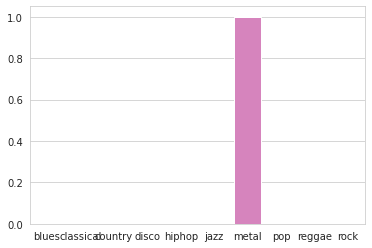

The genre of this song is: metal


In [112]:
df1 = pd.read_csv("Data/features_3_sec.csv")
labels = df1.iloc[:,-1].unique()

sns.barplot(x = labels, y = encoded[0])
plt.show()

print("The genre of this song is:",labels[np.argmax(encoded[0])])